# Lab 3 Report: 
## MNIST Classification with FCN

### Name:

In [1]:
# Import necessary packages

%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

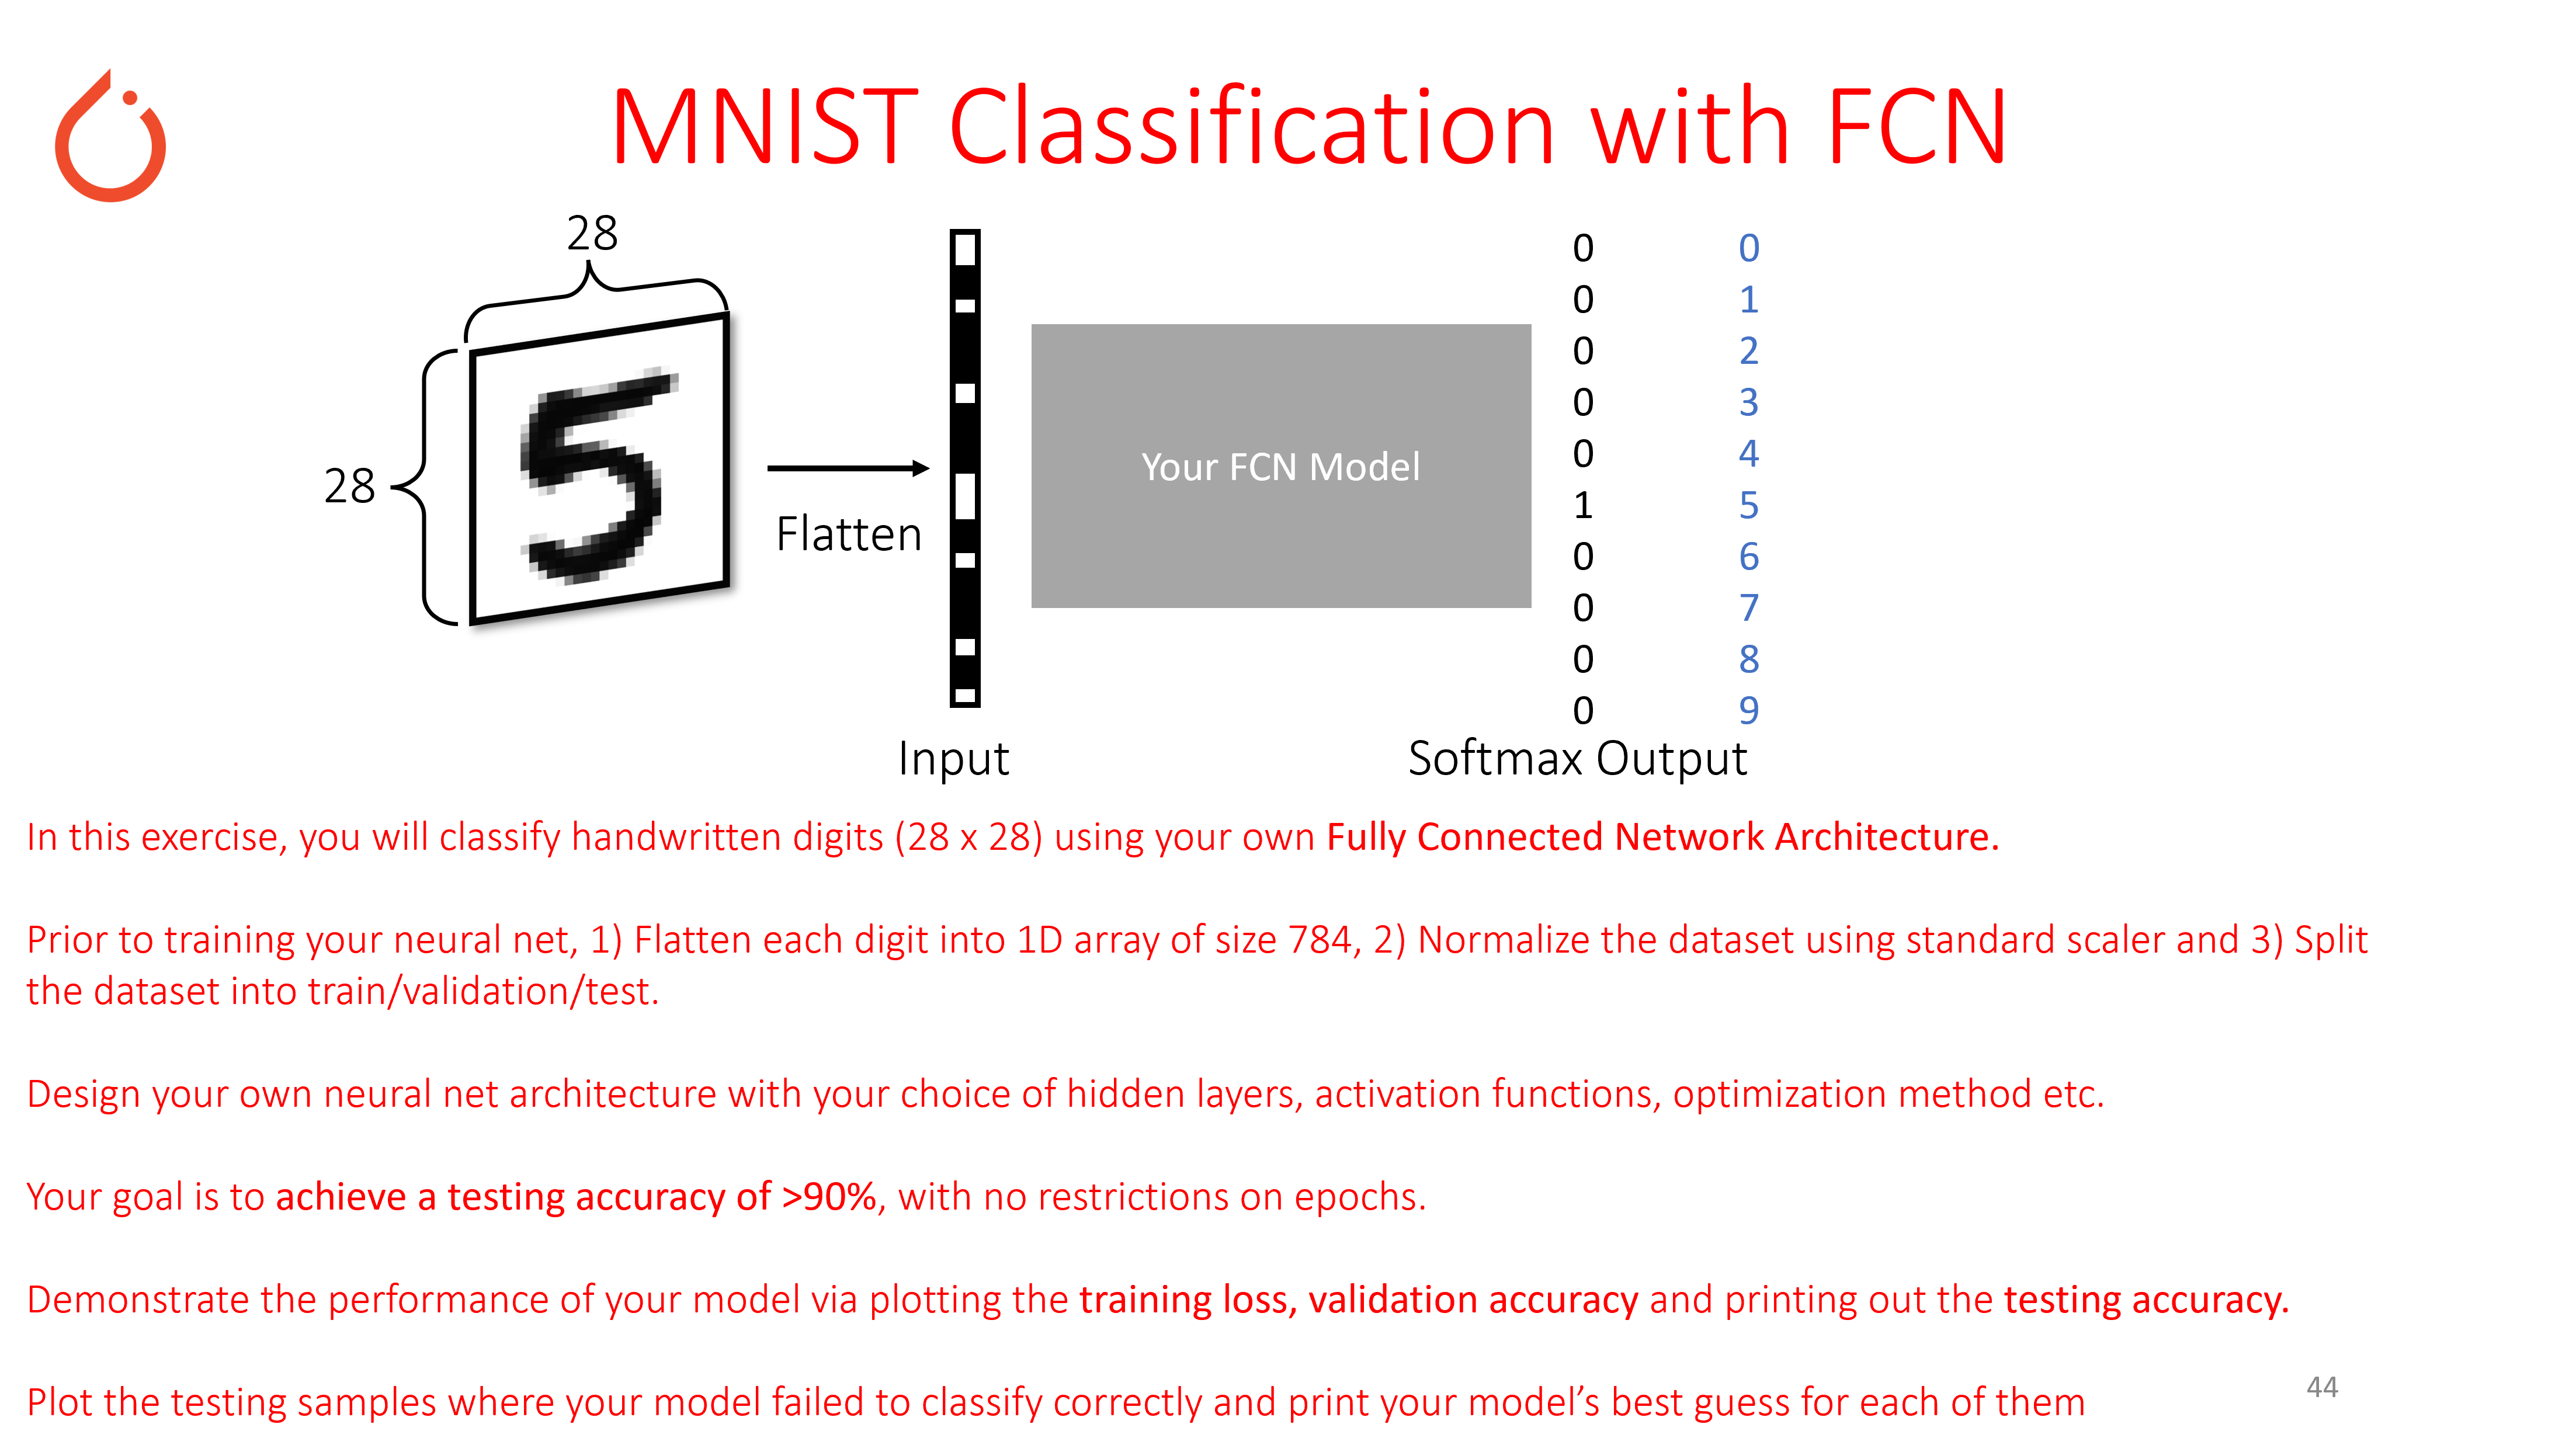

In [3]:
Image('lab3_exercise.PNG', width = 1000)

### Prepare Data

In [4]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit
mnist_train_features = np.load('mnist_train_features.npy') 
mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
mnist_test_features = np.load('mnist_test_features.npy')
mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(mnist_train_features.shape, mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(mnist_test_features.shape, mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


126
5


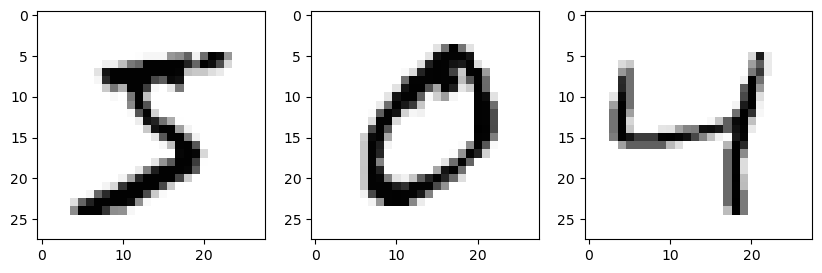

In [5]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(mnist_train_features[2], cmap = 'Greys')

print(mnist_train_features[0][5][16])
print(mnist_train_targets[0])

In [6]:
# Reshape features via flattening the images
# This refers to reshape each sample from a 2d array to a 1d array.
# hint: np.reshape() function could be useful here

mnist_train_features = mnist_train_features.reshape([1000, 784])
mnist_test_features = mnist_test_features.reshape([100, 784])

print(mnist_train_features.shape, mnist_test_features.shape)

(1000, 784) (100, 784)


In [7]:
# Scale the dataset according to standard scaling
# Import necessary functions from scikit-learn library
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

mnist_train_features = scaler.fit_transform(mnist_train_features)
mnist_test_features = scaler.fit_transform(mnist_test_features)

In [8]:
# Split training dataset into Train (90%), Validation (10%)

mnist_validation_features = mnist_train_features[:int(mnist_train_features.shape[0]*0.1)]
mnist_validation_targets = mnist_train_targets[:int(mnist_train_targets.shape[0]*0.1)]

mnist_train_features = mnist_train_features[int(mnist_train_features.shape[0]*0.1) : ]
mnist_train_targets = mnist_train_targets[int(mnist_train_targets.shape[0]*0.1) : ]

print(mnist_validation_features.shape, mnist_validation_targets.shape)
print(mnist_train_features.shape, mnist_train_targets.shape)

(100, 784) (100,)
(900, 784) (900,)


### Define Model

In [9]:
class mnistClassification(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim): # Feel free to add hidden_dim as parameters here
        
        super(mnistClassification, self).__init__()
        
        # YOUR CODE HERE
        self.layer1 = torch.nn.Linear(input_dim, hidden1_dim)
        self.layer2 = torch.nn.Linear(hidden1_dim, hidden2_dim)
        self.layer3 = torch.nn.Linear(hidden2_dim, output_dim)
        
    def forward(self, x):
        
        # YOUR CODE HERE
        out1 = torch.nn.functional.relu(self.layer1(x))
        out2 = torch.nn.functional.relu(self.layer2(out1))
        output = torch.nn.functional.softmax(self.layer3(out2), dim=1)
        
        return output

### Define Hyperparameters

In [10]:
# Initialize our neural network model with input and output dimensions
model = mnistClassification(input_dim=784, output_dim=10, hidden1_dim=300, hidden2_dim=30)

# Define the learning rate and epoch 
learning_rate = 0.005
epochs = 50
# batchsize = # YOUR CODE HERE (If you are using mini-batch gradient)

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    model.cuda()

model

mnistClassification(
  (layer1): Linear(in_features=784, out_features=300, bias=True)
  (layer2): Linear(in_features=300, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=10, bias=True)
)

### Identify Tracked Values

In [11]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = np.zeros((epochs, ))
validation_accuracy_list = np.zeros((epochs, ))

### Train Model

In [12]:
import tqdm

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

# YOUR CODE HERE
train_inputs = torch.from_numpy(mnist_train_features).float()
train_targets = torch.from_numpy(mnist_train_targets).long()

validation_inputs = torch.from_numpy(mnist_validation_features).float()
validation_targets = torch.from_numpy(mnist_validation_targets).long()

testing_inputs = torch.from_numpy(mnist_test_features).float()
testing_targets = torch.from_numpy(mnist_test_targets).long()

# print(train_targets.shape)


# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):
    
    # YOUR CODE HERE
    optimizer.zero_grad()
    train_outputs = model(train_inputs)
    # print(train_outputs.shape)
    loss = loss_func(train_outputs, train_targets)
    train_loss_list[epoch] = loss.item()
    loss.backward()
    optimizer.step()
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    
    # YOUR CODE HERE
    with torch.no_grad():
        validation_outputs = model(validation_inputs)
        correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor)
        validation_accuracy_list[epoch] = correct.mean()


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 223.46it/s]


### Visualize and Evaluate Model

In [13]:
# Import seaborn for prettier plots

import seaborn as sns

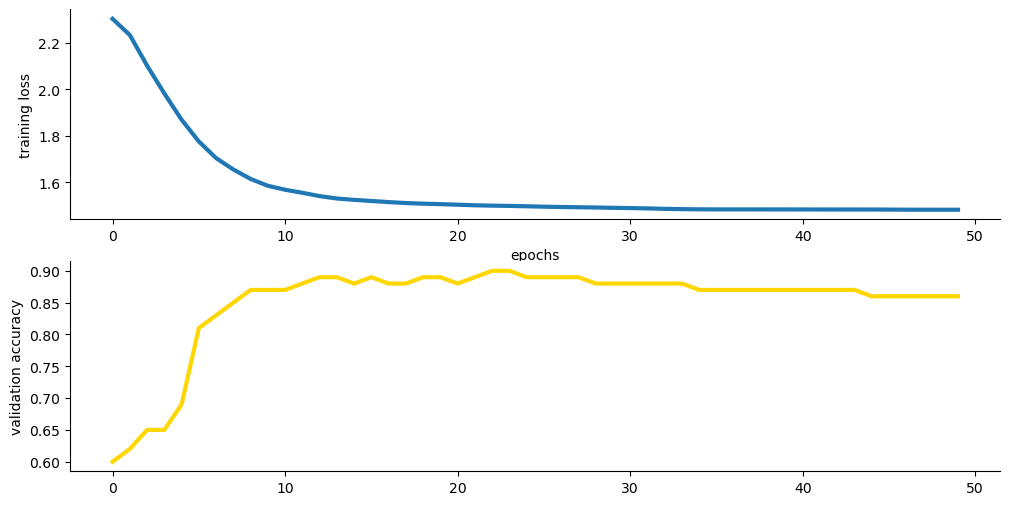

In [14]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [15]:
# Compute the testing accuracy 

# YOUR CODE HERE
testing_outputs = model(testing_inputs)
correct = (torch.argmax(testing_outputs, dim=1) == testing_targets).type(torch.FloatTensor)
print("Testing Accuracy: " + str(correct.mean().numpy()*100) + "%")

Testing Accuracy: 91.00000262260437%


(1, 9)
predicetd: [0, 9, 5, 2, 2]
targets: [4, 4, 3, 8, 3]


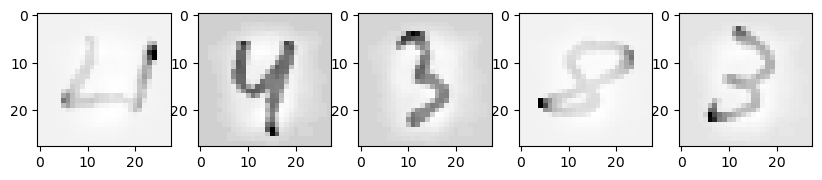

In [17]:
# Plot 5 incorrectly classified testing samples and print the model predictions for each of them
# You can use np.reshape() to convert flattened 1D array back to 2D array

# YOUR CODE HERE
incorrect = (torch.argmax(testing_outputs, dim=1).numpy() == mnist_test_targets)
# print(incorrect)
incorrect_index = np.array(np.where(incorrect == False))
print(incorrect_index.shape)

pred = []
targ = []
plt.figure(figsize = (10, 10))
for i in range(0, 5):
    plt.subplot(1,5,i+1)
    j = incorrect_index[0][i]
    plt.imshow(mnist_test_features[j].reshape([28, 28]), cmap = 'Greys')
    pred.append((torch.argmax(testing_outputs, dim=1)).numpy()[j])
    targ.append(mnist_test_targets[j])
# print("predicetd: " + str((torch.argmax(testing_outputs, dim=1)).numpy()[j]))
print("predicetd: " + str(pred))
print("targets: " + str(targ))
